In [1]:
#perfusion project composition analysis
project_dir = "~/ben_lustre/current_projects/kidney_glomTI_response"
setwd(project_dir)
suppressPackageStartupMessages(source("https://raw.githubusercontent.com/bjstewart1/helpful_singlecell/main/functions.R"))
ad <- import("anndata")
sc <- import("scanpy")
sp = import("scipy")

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


In [2]:
library(miloR)
library(dplyr)

Loading required package: edgeR

Loading required package: limma


Attaching package: ‘limma’


The following object is masked from ‘package:scater’:

    plotMDS


The following object is masked from ‘package:BiocGenerics’:

    plotMA



Attaching package: ‘edgeR’


The following object is masked from ‘package:SingleCellExperiment’:

    cpm



Attaching package: ‘miloR’


The following object is masked from ‘package:igraph’:

    graph



Attaching package: ‘dplyr’


The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union


The following object is masked from ‘package:GenomeInfoDb’:

    intersect


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, inters

In [3]:
#some plotting functions 
plotNhood <- function(x, redDim = "X_umap", color_by = LFC, alpha = 1, 
                      size_scale = c(0.1, 5)){
  layout <- reducedDim(x, redDim)[unlist(x@nhoodIndex), ]
  size <- colSums(x@nhoods)
  df <- data.frame(x= layout[, 1], y = layout[, 2], size = size)
  pl <- ggplot(df, aes(x = x, y=y, 
                       size = size, fill = size)) + geom_point(pch = 21, alpha = alpha, color ="black") +
    theme_void() + scale_size(range = size_scale, name = "Nhood size")
  return(pl)
}
plotNhoodDA <- function(x, redDim = "X_umap",da_results, alpha=1, size_scale = c(0.1, 5),
                        color_scheme = scale_color_gradient2(low = "darkblue", mid ="grey90", high = "darkred" , limits = c(-6, 6))){
  layout <- reducedDim(x, redDim)[unlist(x@nhoodIndex), ]
  size <- colSums(x@nhoods)
  df <- data.frame(x= layout[, 1], y = layout[, 2], size = size)
  LFC <- da_results$logFC
  df <- data.frame(x= layout[, 1], y = layout[, 2], size = size, 
                   LFC = LFC)
  pl <- ggplot(df, aes(x = x, y=y, 
                       size = size, color = LFC)) + ggrastr::geom_point_rast(pch = 19, alpha = alpha) +
    theme_void() + scale_size(range = size_scale, name = "Nhood size") + color_scheme
  return(pl)
}
da_colors <-  scale_color_gradient2(low = "darkred", mid ="grey90", high = "darkblue" , limits = c(-10, 10))
da_fills <-  scale_fill_gradient2(low = "darkred", mid ="grey70", high = "darkblue" , limits = c(-10, 10))

In [4]:
py_config()

python:         /home/jovyan/my-conda-envs/myenv/bin/python
libpython:      /home/jovyan/my-conda-envs/myenv/lib/libpython3.9.so
pythonhome:     /home/jovyan/my-conda-envs/myenv:/home/jovyan/my-conda-envs/myenv
version:        3.9.14 | packaged by conda-forge | (main, Nov 21 2022, 13:18:18)  [GCC 10.4.0]
numpy:          /home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/numpy
numpy_version:  1.22.4

NOTE: Python version was forced by RETICULATE_PYTHON

In [5]:
adata = sc$read_h5ad("data/annotated/scRNAseq_perturbation_kidney.h5ad")

In [6]:
#construct an SCE
library(SingleCellExperiment)

In [7]:
sce = SingleCellExperiment(assays = list('counts' = t(adata$layers['raw_counts']), 'exprs' = t(adata$X) ),
                                    colData = adata$obs, rowData = adata$var)

In [8]:
reducedDims(sce) = list('X_scANVI' = adata$obsm['X_scANVI'], 'X_umap' = adata$obsm['X_umap'])

In [9]:
sce

class: SingleCellExperiment 
dim: 3177 43193 
metadata(0):
assays(2): counts exprs
rownames(3177): A2M A2ML1-AS1 ... ZSWIM5 ZSWIM6
rowData names(16): ID Symbol ... variances_norm
  highly_variable_nbatches
colnames(43193):
  AAACCCAAGCTCGTGC-1_cellranger700_count_41742_WSSS_A_KID11165952_GRCh38-2020-A
  AAACCCAAGGCAGGGA-1_cellranger700_count_41742_WSSS_A_KID11165952_GRCh38-2020-A
  ...
  TTTGTTGGTTGCGGAA-1_cellranger700_count_45058_KID_CZI12929934_GRCh38-2020-A
  TTTGTTGGTTTGGGTT-1_cellranger700_count_45058_KID_CZI12929934_GRCh38-2020-A
colData names(67): barcode path ... celltypist_immune_predictions
  cell_type
reducedDimNames(2): X_scANVI X_umap
mainExpName: NULL
altExpNames(0):

In [10]:
#make a milo object for this analysis
milo <- Milo(sce)

In [11]:
#build the k=30 kNN graph
d = ncol(reducedDim(sce, 'X_scANVI'))
k = 30
milo <- buildGraph(milo, k = k, d=d, reduced.dim = "X_scANVI")

Constructing kNN graph with k:30



In [12]:
milo <- makeNhoods(milo, prop = 0.1, k = k, d=d, refined = TRUE, reduced_dims = "X_scANVI")

Checking valid object

Running refined sampling with reduced_dim



In [13]:
milo <- calcNhoodDistance(milo, d=d, reduced.dim = "X_scANVI")

'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



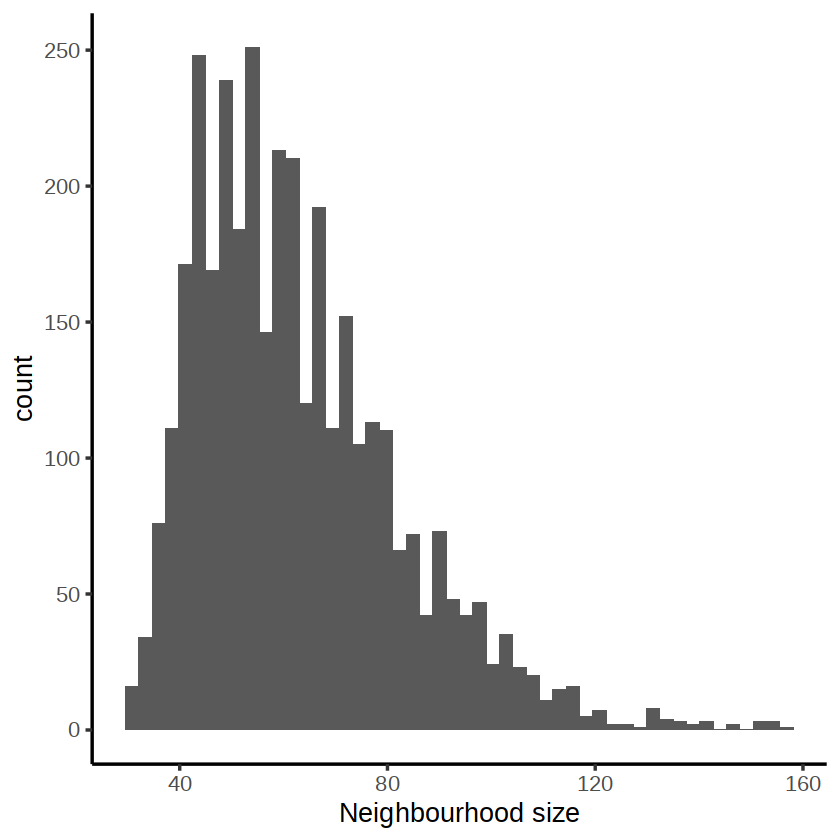

In [14]:
plotNhoodSizeHist(milo)

In [15]:
table(colData(milo)$kidney)


K281 K282 K283 K287 K288 K289 K290 
8728 4553 5756 6893 2924 8090 6249 

In [16]:
colData(milo)$replicate = paste0(colData(milo)$kidney, "_", colData(milo)$channel) #kidneys are across multiple channels, so we have more replicates.

In [17]:
milo <- countCells(milo, meta.data = as.data.frame(colData(milo)), sample="replicate")

Checking meta.data validity

Counting cells in neighbourhoods



In [18]:
#get a design
design <- data.frame(colData(milo))[,c("replicate", "stimulation")]

In [19]:
design <- dplyr::distinct(design)
rownames(design) <- design$replicate

In [20]:
da_results <- testNhoods(milo, design = ~ stimulation, norm.method = 'logMS',
                         design.df = design, reduced.dim = 'X_scANVI')

Using logMS normalisation

Performing spatial FDR correction withk-distance weighting



In [21]:
da_results %>%
  arrange(SpatialFDR) %>%
  head() 

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
79,6.030555,9.341659,30.30187,3.820974e-08,6.062338e-06,79,6.52348e-06
80,5.913758,9.266255,30.00462,4.449683e-08,6.062338e-06,80,6.52348e-06
92,6.481684,9.658923,32.67657,1.130097e-08,6.062338e-06,92,6.52348e-06
202,5.869388,9.243772,29.87504,4.757887e-08,6.062338e-06,202,6.52348e-06
286,5.823773,9.216219,29.71584,5.161304e-08,6.062338e-06,286,6.52348e-06
554,5.851367,9.234595,29.84632,4.826652e-08,6.062338e-06,554,6.52348e-06


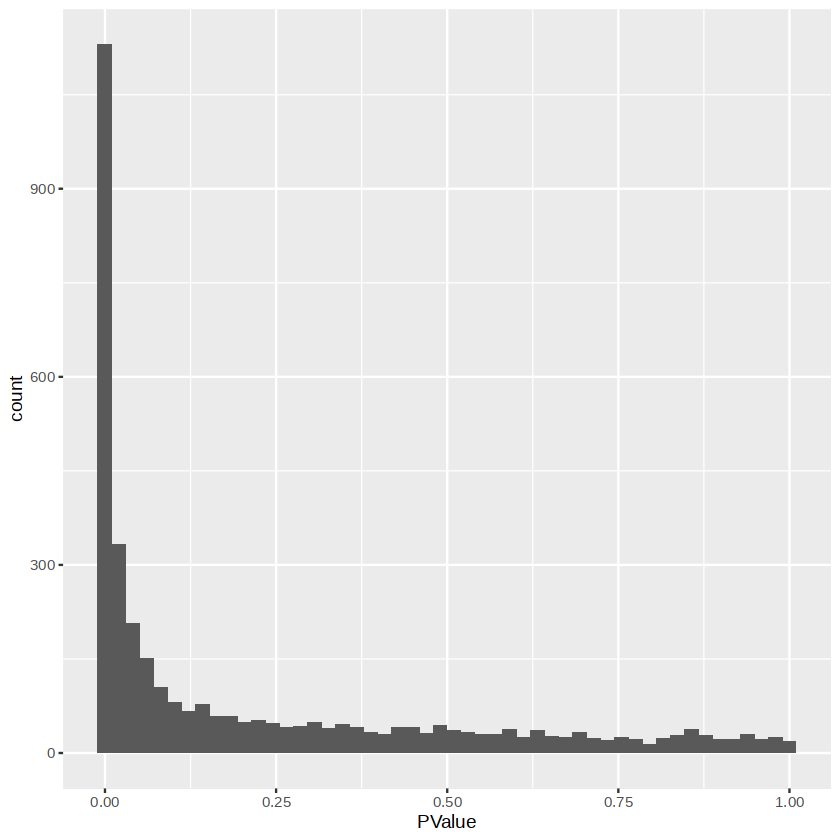

In [22]:
ggplot(da_results, aes(PValue)) + geom_histogram(bins=50)

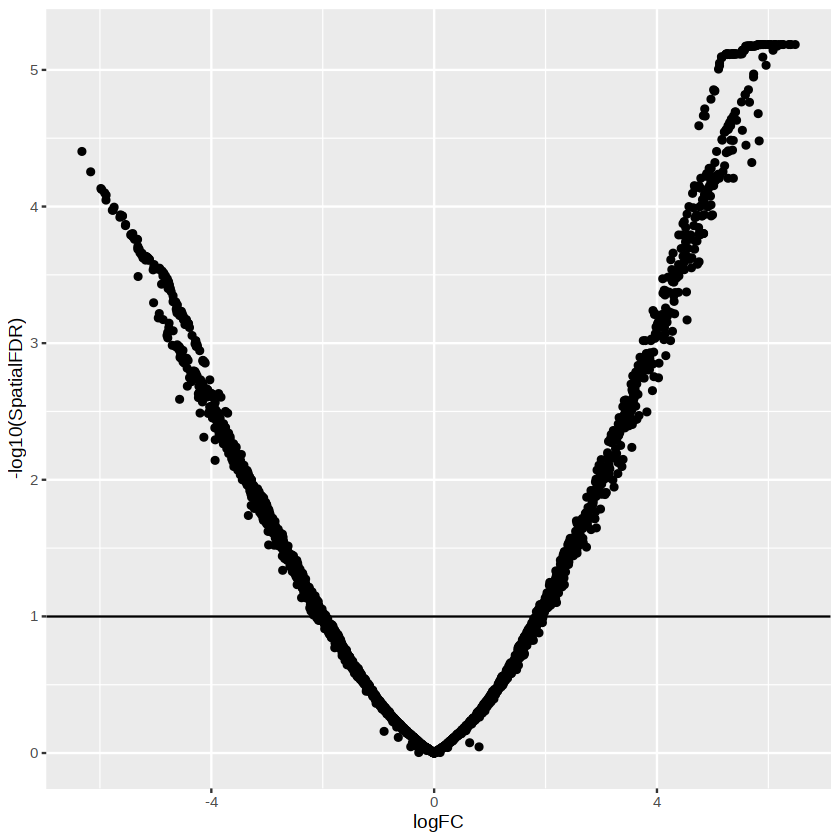

In [23]:
ggplot(da_results, aes(logFC, -log10(SpatialFDR))) + 
  geom_point() +
  geom_hline(yintercept = 1) ## Mark significance threshold (10% FDR)

In [24]:
milo <- buildNhoodGraph(milo)

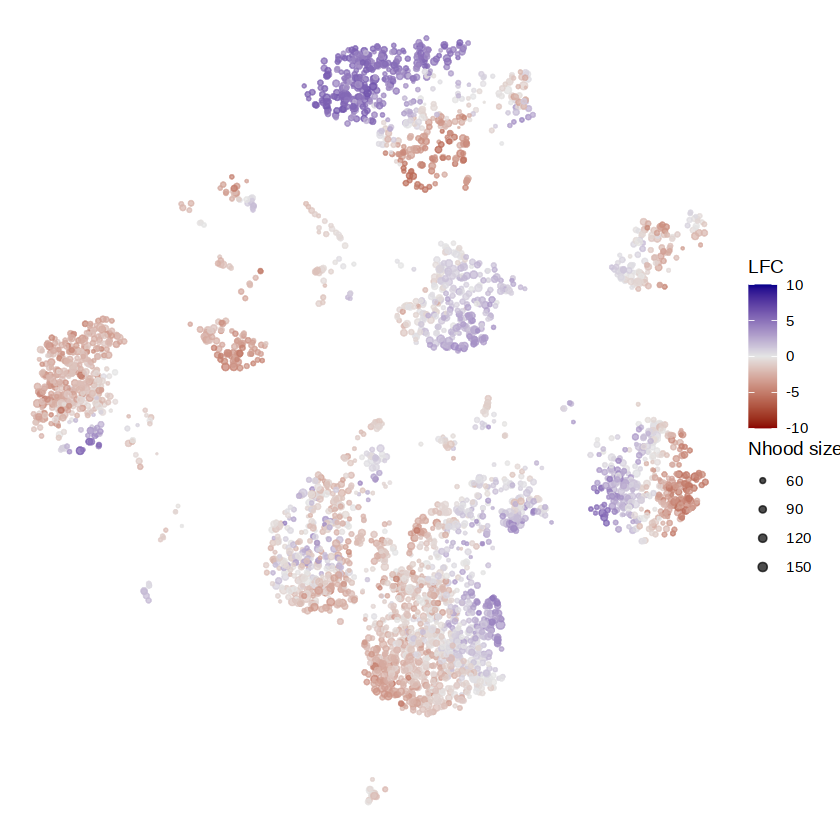

In [25]:
plotNhoodDA(milo,redDim = "X_umap",  da_results, alpha=0.7, size_scale = c(0.1, 2), color_scheme = da_colors)

In [26]:
da_results <- annotateNhoods(milo, da_results, coldata_col = "cell_type")
head(da_results)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,cell_type,cell_type_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,0.4358801,8.937549,0.2020436,6.530893e-01,7.402464e-01,1,7.393543e-01,CD8_T_cell,1.0000000
2,-0.6213148,9.094022,0.4103260,5.218236e-01,6.334150e-01,2,6.328195e-01,CD4_T_cell_Th1,1.0000000
3,-1.1409980,8.432523,1.3992610,2.368847e-01,3.544786e-01,3,3.540829e-01,GPEC,0.9473684
4,5.2803760,8.895912,27.4523049,1.653944e-07,6.737029e-06,4,7.641906e-06,nonclassical_monocyte,1.0000000
5,-1.3985970,9.118558,2.1304544,1.444397e-01,2.419365e-01,5,2.427823e-01,CD8_T_cell,0.9024390
6,1.7061963,9.541966,3.1616233,7.542856e-02,1.454899e-01,6,1.464346e-01,NK1,1.0000000


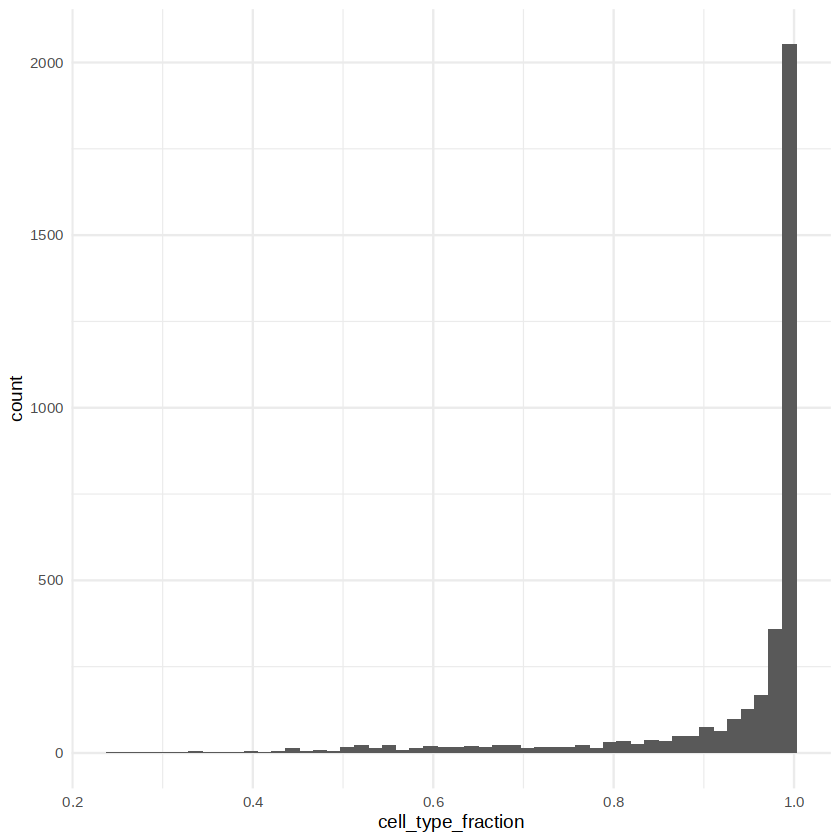

In [27]:
ggplot(da_results, aes(cell_type_fraction)) + geom_histogram(bins=50) + theme_minimal()

In [28]:
da_results$cell_type <- ifelse(da_results$cell_type_fraction < 0.7, "Mixed", da_results$cell_type)

Converting group_by to factor...



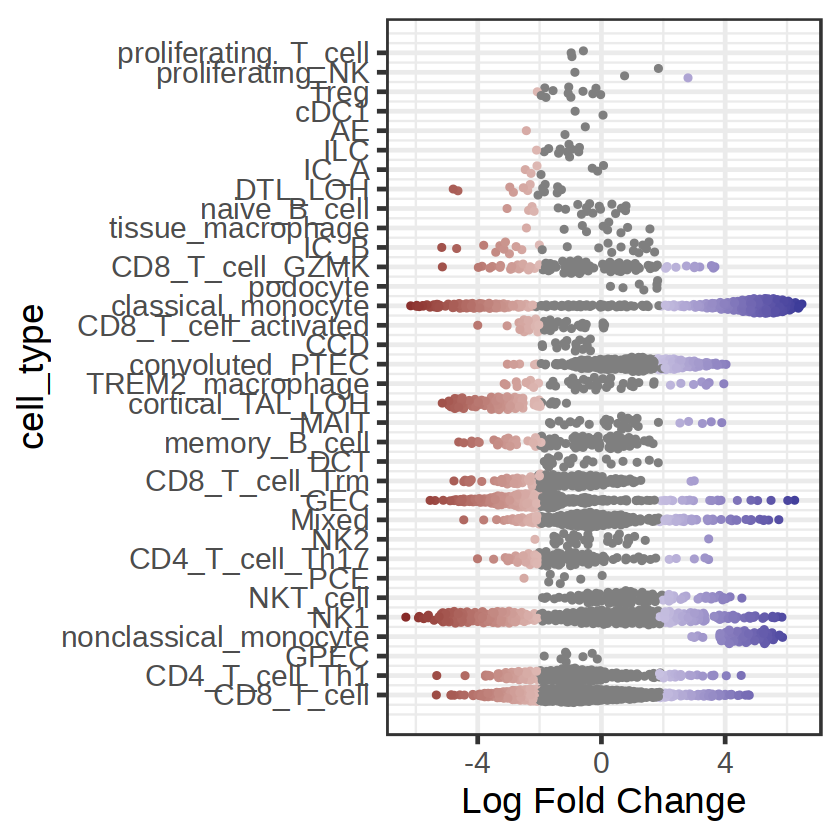

In [29]:
plotDAbeeswarm(da_results, group.by = "cell_type")

In [30]:
#save the milo result
saveRDS(milo, "data/da_results/perfusion/perfusion_milo.RDS")
saveRDS(da_results, "data/da_results/perfusion/da_results.RDS")